In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")

2024-06-24 10:47:52.898803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 10:47:52.898857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 10:47:52.900359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pickle

# Path to the serialized object
file_path = '/kaggle/input/histopathology-breast-images-lists/breast_img_list.pkl'

# Deserializing the list
with open(file_path, 'rb') as file:
    loaded_breast_img = pickle.load(file)

In [3]:
breast_img = loaded_breast_img

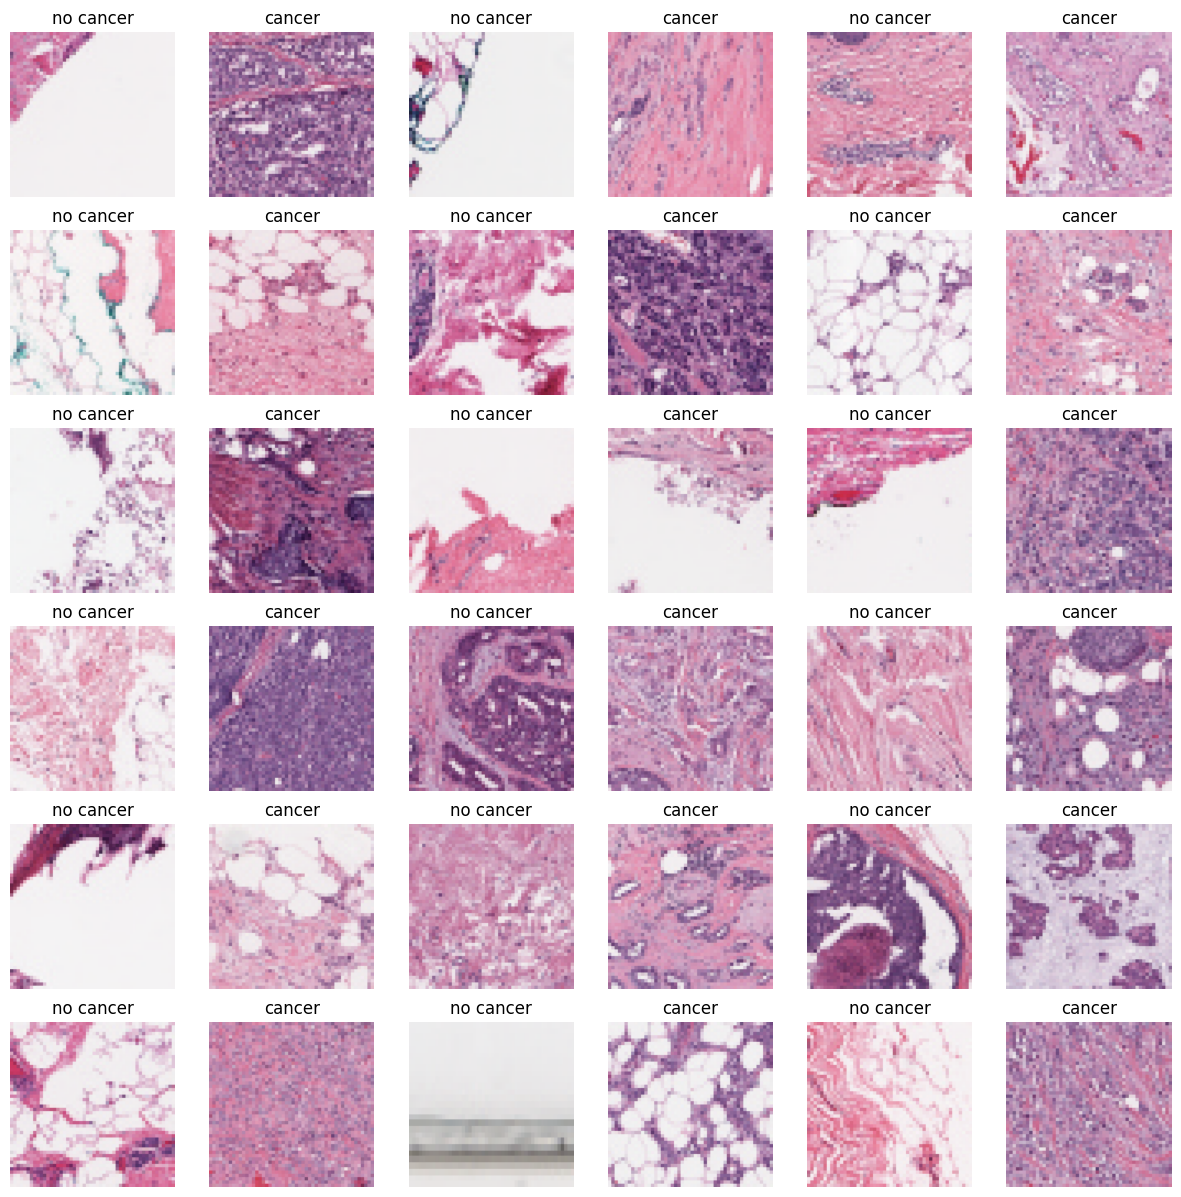

In [4]:


class BreastHistopathology:
    def __init__(self, data_path, breast_image):
        self.data_path = data_path
        self.breast_img = breast_image
        self.Negative_Cases = []
        self.Positive_Cases = []
        self.load_data()

    def load_data(self):
        for img in self.breast_img:
            if img[-5] == '0':
                self.Negative_Cases.append(img)
            elif img[-5] == '1':
                self.Positive_Cases.append(img)

    def visualize_sample_images(self):
        plt.figure(figsize=(15, 15))
        some_non = np.random.randint(0, len(self.Negative_Cases), 18)
        some_can = np.random.randint(0, len(self.Positive_Cases), 18)

        for i, num in enumerate(some_non):
            img = image.load_img((self.Negative_Cases[num]), target_size=(100, 100))
            img = image.img_to_array(img)
            plt.subplot(6, 6, 2*i+1)
            plt.axis('off')
            plt.title('no cancer')
            plt.imshow(img.astype('uint8'))

        for i, num in enumerate(some_can):
            img = image.load_img((self.Positive_Cases[num]), target_size=(100, 100))
            img = image.img_to_array(img)
            plt.subplot(6, 6, 2*i+2)
            plt.axis('off')
            plt.title('cancer')
            plt.imshow(img.astype('uint8'))

    def prepare_dataset(self):
        non_img_arr = [self.process_image(img, 0) for img in self.Negative_Cases[:78786]]
        can_img_arr = [self.process_image(img, 1) for img in self.Positive_Cases]
        
        min_size = min(len(non_img_arr), len(can_img_arr))
        breast_img_arr = np.array(non_img_arr[:min_size] + can_img_arr[:min_size], dtype=object)
        
        np.random.shuffle(breast_img_arr)
        X = np.array([item[0] for item in breast_img_arr])
        y = np.array([item[1] for item in breast_img_arr])
        return X, y

    def process_image(self, img_path, label):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
        return [img_resized, label]

    def split_data(self, X, y):
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)
        Y_train = to_categorical(Y_train, num_classes=2)
        Y_test = to_categorical(Y_test, num_classes=2)
        return X_train, X_test, Y_train, Y_test

    def describe_data(self, X, y):
        print('Total number of images:', len(X))
        print('Number of Non-Cancer Cases:', np.sum(y == 0))
        print('Number of Cancer Cases:', np.sum(y == 1))
        print('Image shape (Width, Height, Channels):', X[0].shape)


# Example usage:
dataset = BreastHistopathology('/kaggle/input/breast-histopathology-images', breast_img)
dataset.visualize_sample_images()


In [5]:
X, y = dataset.prepare_dataset()
X_train, X_test, Y_train, Y_test = dataset.split_data(X, y)

In [8]:
dataset.describe_data(X, y)

Total number of images: 157572
Number of Non-Cancer Cases: 78786
Number of Cancer Cases: 78786
Image shape (Width, Height, Channels): (50, 50, 3)


  29/1478 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

I0000 00:00:1719225618.300946     411 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1478/1478 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step
EfficientNetB0 - Accuracy: 0.9100313081739719 AUC: 0.9722033895507775 Time taken: 24.483539581298828 s
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     23748
           1       0.88      0.95      0.91     23524

    accuracy                           0.91     47272
   macro avg       0.91      0.91      0.91     47272
weighted avg       0.91      0.91      0.91     47272

1478/1478 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step
MobileNetV3 - Accuracy: 0.9164410221695718 AUC: 0.9727309207964303 Time taken: 14.750757217407227 s
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     23748
           1       0.91      0.92      0.92     23524

    accuracy                           0.92     47272
   macro avg       0.92      0.92      0.92     47272
weighted avg       0.92      0.92      0.92     47272



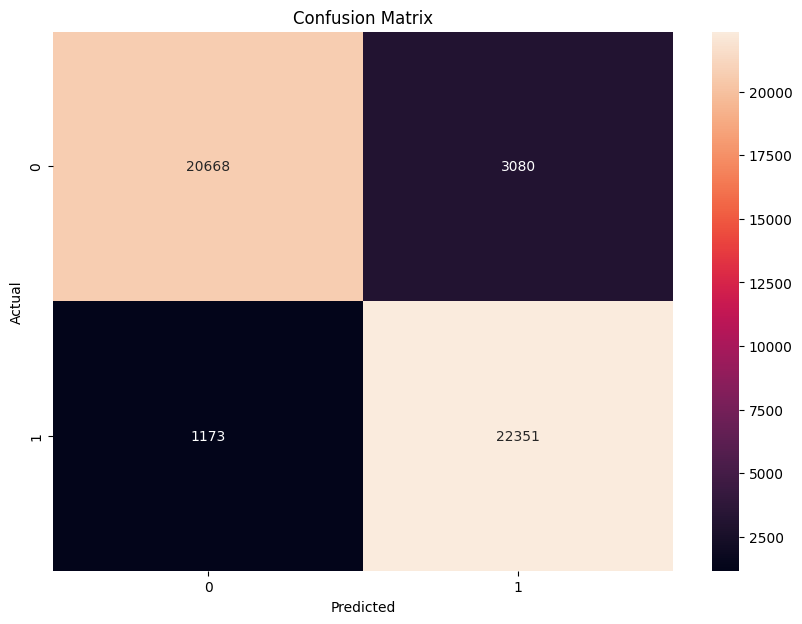

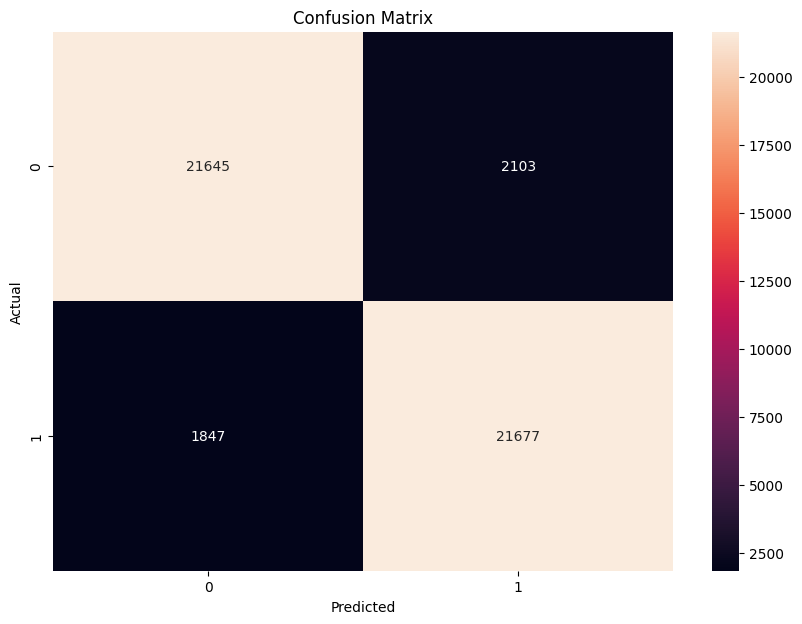

In [8]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import seaborn as sns
import time

def evaluate_model(model_path, X_test, Y_test):
    model = load_model(model_path)
    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    predicted_classes = predictions.argmax(axis=1)
    true_classes = Y_test.argmax(axis=1)
    
    # Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    auc = roc_auc_score(Y_test, predictions, multi_class='ovo')
    
    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Classification Report
    class_report = classification_report(true_classes, predicted_classes)
    
    return accuracy, auc, class_report, prediction_time

# Paths to the models
eff_net_b0_path = '/kaggle/input/breast-histopathology-images-trained-models/best_model_eff_netb0.keras'
mob_net_v3_path = '/kaggle/input/breast-histopathology-images-trained-models/best_model_mobnetv3.keras'

# Evaluating each model
acc_eff_net_b0, auc_eff_net_b0, report_eff_net_b0, time_eff_net_b0 = evaluate_model(eff_net_b0_path, X_test, Y_test)
print("EfficientNetB0 - Accuracy:", acc_eff_net_b0, "AUC:", auc_eff_net_b0, "Time taken:", time_eff_net_b0, "s")
print(report_eff_net_b0)

acc_mob_net_v3, auc_mob_net_v3, report_mob_net_v3, time_mob_net_v3 = evaluate_model(mob_net_v3_path, X_test, Y_test)
print("MobileNetV3 - Accuracy:", acc_mob_net_v3, "AUC:", auc_mob_net_v3, "Time taken:", time_mob_net_v3, "s")
print(report_mob_net_v3)


In [10]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.5 MB/s eta 0:00:00ta 0:00:01


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
# import seaborn as sns
# import time


# def convert_to_tflite_and_evaluate(model_path, X_test, Y_test):
#     # Load the original model
#     model = load_model(model_path)

#     # Convert to TensorFlow Lite with quantization
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     tflite_model = converter.convert()

#     # Save the model to a file (optional, if you need to keep it)
#     with open('quantized_model.tflite', 'wb') as f:
#         f.write(tflite_model)

#     # Load the TFLite model and allocate tensors
#     interpreter = tf.lite.Interpreter(model_content=tflite_model)
#     interpreter.allocate_tensors()

#     # Get input and output tensors
#     input_details = interpreter.get_input_details()
#     output_details = interpreter.get_output_details()

#     # Run predictions on the entire test set
#     predictions = []
#     for i in range(len(X_test)):
#         input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)
#         interpreter.set_tensor(input_details[0]['index'], input_data)
#         interpreter.invoke()
#         output_data = interpreter.get_tensor(output_details[0]['index'])
#         predictions.append(output_data[0])

#     # Evaluate predictions
#     predicted_classes = np.argmax(predictions, axis=1)
#     true_classes = np.argmax(Y_test, axis=1)
#     accuracy = accuracy_score(true_classes, predicted_classes)
#     auc = roc_auc_score(Y_test, predictions, multi_class='ovo')

#     # Confusion Matrix
#     cm = confusion_matrix(true_classes, predicted_classes)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title('Confusion Matrix')
#     plt.ylabel('Actual Label')
#     plt.xlabel('Predicted Label')
#     plt.show()

#     report = classification_report(true_classes, predicted_classes)
#     return accuracy, auc, report

# # Paths to the models
# eff_net_b0_path = '/kaggle/input/breast-histopathology-images-trained-models/best_model_eff_netb0.keras'
# mob_net_v3_path = '/kaggle/input/breast-histopathology-images-trained-models/best_model_mobnetv3.keras'

# # Convert, quantize with TFLite, and evaluate
# acc_tflite, auc_tflite, report_tflite = convert_to_tflite_and_evaluate(mob_net_v3_path, X_test, Y_test)
# print("TFLite Quantized Model - Accuracy:", acc_tflite, "AUC:", auc_tflite)
# print("Classification Report:\n", report_tflite)


In [ ]:
# import tensorflow_model_optimization as tfmot
# from tensorflow.keras.models import load_model

# def quantize_and_evaluate(model_path, X_test, Y_test):
#     model = load_model(model_path)
#     quantize_model = tfmot.quantization.keras.quantize_model
#     q_model = quantize_model(model)
#     q_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
#     q_model.summary()
    
#     # Evaluate the quantized model
#     acc, auc, report, prediction_time = evaluate_model(q_model, X_test, Y_test)
#     return acc, auc, report, prediction_time

# # Quantize and evaluate EfficientNetB0
# acc_q_eff_net_b0, auc_q_eff_net_b0, report_q_eff_net_b0, time_q_eff_net_b0 = quantize_and_evaluate(eff_net_b0_path, X_test, Y_test)
# print("Quantized EfficientNetB0 - Accuracy:", acc_q_eff_net_b0, "AUC:", auc_q_eff_net_b0, "Time taken:", time_q_eff_net_b0, "s")
# print(report_q_eff_net_b0)

# # Quantize and evaluate MobileNetV3
# acc_q_mob_net_v3, auc_q_mob_net_v3, report_q_mob_net_v3, time_q_mob_net_v3 = quantize_and_evaluate(mob_net_v3_path, X_test, Y_test)
# print("Quantized MobileNetV3 - Accuracy:", acc_q_mob_net_v3, "AUC:", auc_q_mob_net_v3, "Time taken:", time_q_mob_net_v3, "s")
# print(report_q_mob_net_v3)


In [13]:
model = load_model(eff_net_b0_path)
print(model.summary())

# If this prints without errors and the model structure looks like a typical Sequential or Functional model,
# then proceed with quantization.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,140,664 (69.20 MB)

 Trainable params: 6,025,746 (22.99 MB)

 Non-trainable params: 63,424 (247.75 KB)

 Optimizer params: 12,051,494 (45.97 MB)

None


In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import seaborn as sns
import time


1478/1478 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


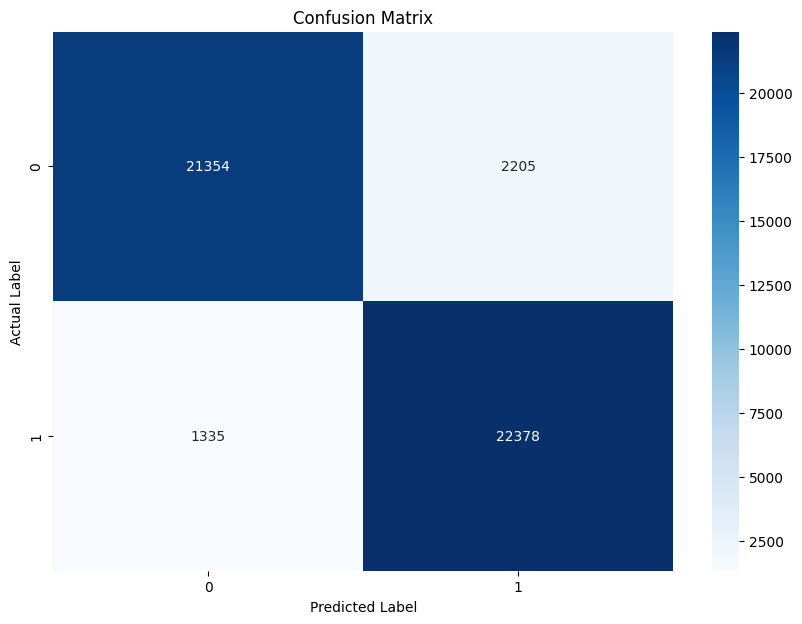

Ensemble model accuracy: 0.9251142325266543
Ensemble model AUC: 0.9781318815388831
Total prediction time: 34.11260437965393 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     23559
           1       0.91      0.94      0.93     23713

    accuracy                           0.93     47272
   macro avg       0.93      0.93      0.93     47272
weighted avg       0.93      0.93      0.93     47272



In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

def ensemble_models(models, X_test):
    start_time = time.time()
    predictions = [model.predict(X_test) for model in models]
    ensemble_predictions = np.mean(predictions, axis=0)
    end_time = time.time()
    prediction_time = end_time - start_time
    return ensemble_predictions, prediction_time

q_eff_net_b0 = load_model('/kaggle/input/breast-histopathology-images-trained-models/best_model_eff_netb0.keras')
q_mob_net_v3 = load_model('/kaggle/input/breast-histopathology-images-trained-models/best_model_mobnetv3.keras')

# Ensemble predictions
ensemble_predictions, prediction_time = ensemble_models([q_eff_net_b0, q_mob_net_v3], X_test)
ensemble_pred_classes = ensemble_predictions.argmax(axis=1)
true_classes = Y_test.argmax(axis=1)

# Accuracy
accuracy_ensemble = accuracy_score(true_classes, ensemble_pred_classes)

# AUC
auc_ensemble = roc_auc_score(Y_test, ensemble_predictions, multi_class='ovo')

# Confusion Matrix
cm = confusion_matrix(true_classes, ensemble_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
report_ensemble = classification_report(true_classes, ensemble_pred_classes)

# Output results
print("Ensemble model accuracy:", accuracy_ensemble)
print("Ensemble model AUC:", auc_ensemble)
print("Total prediction time:", prediction_time, "seconds")
print("Classification Report:\n", report_ensemble)


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def convert_to_functional(model):
    # Assuming the model's input and output are accessible
    inputs = model.input
    outputs = model.output
    return Model(inputs=inputs, outputs=outputs)

model = load_model('/kaggle/input/breast-histopathology-images-trained-models/best_model_mobnetv3.keras')
model = convert_to_functional(model)  # Convert to functional if it's subclassed


In [18]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,842 (9.26 MB)

 Trainable params: 2,390,914 (9.12 MB)

 Non-trainable params: 36,928 (144.25 KB)

In [17]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model

def quantize_and_evaluate(model, X_test, Y_test):
    quantize_model = tfmot.quantization.keras.quantize_model
    q_model = quantize_model(model)
    q_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    q_model.summary()
    
    # Evaluate the quantized model
    acc, auc, report, prediction_time = evaluate_model(q_model, X_test, Y_test)
    return acc, auc, report, prediction_time

# # Quantize and evaluate EfficientNetB0
# acc_q_eff_net_b0, auc_q_eff_net_b0, report_q_eff_net_b0, time_q_eff_net_b0 = quantize_and_evaluate(eff_net_b0_path, X_test, Y_test)
# print("Quantized EfficientNetB0 - Accuracy:", acc_q_eff_net_b0, "AUC:", auc_q_eff_net_b0, "Time taken:", time_q_eff_net_b0, "s")
# print(report_q_eff_net_b0)

# Quantize and evaluate MobileNetV3
acc_q_mob_net_v3, auc_q_mob_net_v3, report_q_mob_net_v3, time_q_mob_net_v3 = quantize_and_evaluate(model, X_test, Y_test)
print("Quantized MobileNetV3 - Accuracy:", acc_q_mob_net_v3, "AUC:", auc_q_mob_net_v3, "Time taken:", time_q_mob_net_v3, "s")
print(report_q_mob_net_v3)


ValueError: `to_quantize` can only either be a keras Sequential or Functional model.